In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math
import time
import matplotlib.pyplot as plt


In [4]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle (1).json to kaggle (1).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download -d wentinglu/highfrequency-futures-data-china


Dataset URL: https://www.kaggle.com/datasets/wentinglu/highfrequency-futures-data-china
License(s): CC-BY-SA-4.0
100% 466M/467M [00:23<00:00, 24.0MB/s]
100% 467M/467M [00:23<00:00, 21.1MB/s]


In [6]:
!mkdir -p high-frequency_dataset


In [7]:
!unzip highfrequency-futures-data-china.zip -d high-frequency_dataset


Archive:  highfrequency-futures-data-china.zip
  inflating: high-frequency_dataset/minDataSum/A.csv  
  inflating: high-frequency_dataset/minDataSum/AG.csv  
  inflating: high-frequency_dataset/minDataSum/AL.csv  
  inflating: high-frequency_dataset/minDataSum/AP.csv  
  inflating: high-frequency_dataset/minDataSum/AU.csv  
  inflating: high-frequency_dataset/minDataSum/B.csv  
  inflating: high-frequency_dataset/minDataSum/BU.csv  
  inflating: high-frequency_dataset/minDataSum/C.csv  
  inflating: high-frequency_dataset/minDataSum/CF.csv  
  inflating: high-frequency_dataset/minDataSum/CJ.csv  
  inflating: high-frequency_dataset/minDataSum/CS.csv  
  inflating: high-frequency_dataset/minDataSum/CU.csv  
  inflating: high-frequency_dataset/minDataSum/CY.csv  
  inflating: high-frequency_dataset/minDataSum/EB.csv  
  inflating: high-frequency_dataset/minDataSum/EG.csv  
  inflating: high-frequency_dataset/minDataSum/FB.csv  
  inflating: high-frequency_dataset/minDataSum/FG.csv  
  in

In [8]:
print("Listing files in 'high-frequency_dataset' directory after extraction:")
for root, dirs, files in os.walk('high-frequency_dataset'):
    for filename in files:
        print(f"Found file: {os.path.join(root, filename)}")

Listing files in 'high-frequency_dataset' directory after extraction:
Found file: high-frequency_dataset/minDataSum/SN.csv
Found file: high-frequency_dataset/minDataSum/I.csv
Found file: high-frequency_dataset/minDataSum/AU.csv
Found file: high-frequency_dataset/minDataSum/AL.csv
Found file: high-frequency_dataset/minDataSum/FU.csv
Found file: high-frequency_dataset/minDataSum/IH.csv
Found file: high-frequency_dataset/minDataSum/SF.csv
Found file: high-frequency_dataset/minDataSum/CY.csv
Found file: high-frequency_dataset/minDataSum/PG.csv
Found file: high-frequency_dataset/minDataSum/TS.csv
Found file: high-frequency_dataset/minDataSum/UR.csv
Found file: high-frequency_dataset/minDataSum/SM.csv
Found file: high-frequency_dataset/minDataSum/FG.csv
Found file: high-frequency_dataset/minDataSum/EB.csv
Found file: high-frequency_dataset/minDataSum/MA.csv
Found file: high-frequency_dataset/minDataSum/SR.csv
Found file: high-frequency_dataset/minDataSum/JM.csv
Found file: high-frequency_dat

In [9]:
def load_data_from_folder(folder_path, file_extension='.csv'):  # Adjust extension as needed
    data_frames = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(file_extension):  # Adjust the extension as needed
                file_path = os.path.join(root, file)
                print(f"Loading {file_path}")
                df = pd.read_csv(file_path)  # Adjust parameters as needed
                data_frames.append(df)
    if not data_frames:
        raise ValueError(f"No {file_extension} files found in the specified folder.")
    return pd.concat(data_frames, ignore_index=True)

# Specify the folder containing the dataset
dataset_folder = 'high-frequency_dataset'
df = load_data_from_folder(dataset_folder)

Loading high-frequency_dataset/minDataSum/SN.csv
Loading high-frequency_dataset/minDataSum/I.csv
Loading high-frequency_dataset/minDataSum/AU.csv
Loading high-frequency_dataset/minDataSum/AL.csv
Loading high-frequency_dataset/minDataSum/FU.csv
Loading high-frequency_dataset/minDataSum/IH.csv
Loading high-frequency_dataset/minDataSum/SF.csv
Loading high-frequency_dataset/minDataSum/CY.csv
Loading high-frequency_dataset/minDataSum/PG.csv
Loading high-frequency_dataset/minDataSum/TS.csv
Loading high-frequency_dataset/minDataSum/UR.csv
Loading high-frequency_dataset/minDataSum/SM.csv
Loading high-frequency_dataset/minDataSum/FG.csv
Loading high-frequency_dataset/minDataSum/EB.csv
Loading high-frequency_dataset/minDataSum/MA.csv
Loading high-frequency_dataset/minDataSum/SR.csv
Loading high-frequency_dataset/minDataSum/JM.csv
Loading high-frequency_dataset/minDataSum/PB.csv
Loading high-frequency_dataset/minDataSum/EG.csv
Loading high-frequency_dataset/minDataSum/NI.csv
Loading high-frequenc

In [10]:
df

,Time,Open,High,Low,Close,Volume,Amount,Open Interest
0,2015-03-27 20:59:00.005004,1.000000,1.000000,1.000000,1.000000,2.0,238540.0,610.0
1,2015-03-27 21:00:00.005000,0.999665,0.999665,0.993628,0.994802,32.0,3802040.0,598.0
2,2015-03-27 21:01:00.004997,0.995221,0.995221,0.994382,0.994382,16.0,1898500.0,612.0
3,2015-03-27 21:02:00.005003,0.994382,0.996143,0.993879,0.996143,12.0,1424740.0,616.0
4,2015-03-27 21:03:00.005000,0.993796,0.995556,0.993796,0.995556,6.0,712020.0,618.0
...,...,...,...,...,...,...,...,...
25158886,2021-02-01 22:55:00.210,2.939837,2.942166,2.938672,2.942166,506.0,127716350.0,150510.0
25158887,2021-02-01 22:56:00.209,2.941584,2.943913,2.941584,2.943913,381.0,96266800.0,150411.0
25158888,2021-02-01 22:57:00.224,2.943331,2.945078,2.942749,2.945078,326.0,82391800.0,150319.0
25158889,2021-02-01 22:58:00.187,2.945661,2.946825,2.945078,2.946243,507.0,128235500.0,150109.0


In [11]:
df.isnull().sum()

,0
Time,0
Open,20272
High,20272
Low,20272
Close,20272
Volume,0
Amount,0
Open Interest,0


In [12]:
df.dropna(inplace=True)

In [13]:
df.isnull().sum()

,0
Time,0
Open,0
High,0
Low,0
Close,0
Volume,0
Amount,0
Open Interest,0


In [14]:
df

,Time,Open,High,Low,Close,Volume,Amount,Open Interest
0,2015-03-27 20:59:00.005004,1.000000,1.000000,1.000000,1.000000,2.0,238540.0,610.0
1,2015-03-27 21:00:00.005000,0.999665,0.999665,0.993628,0.994802,32.0,3802040.0,598.0
2,2015-03-27 21:01:00.004997,0.995221,0.995221,0.994382,0.994382,16.0,1898500.0,612.0
3,2015-03-27 21:02:00.005003,0.994382,0.996143,0.993879,0.996143,12.0,1424740.0,616.0
4,2015-03-27 21:03:00.005000,0.993796,0.995556,0.993796,0.995556,6.0,712020.0,618.0
...,...,...,...,...,...,...,...,...
25158886,2021-02-01 22:55:00.210,2.939837,2.942166,2.938672,2.942166,506.0,127716350.0,150510.0
25158887,2021-02-01 22:56:00.209,2.941584,2.943913,2.941584,2.943913,381.0,96266800.0,150411.0
25158888,2021-02-01 22:57:00.224,2.943331,2.945078,2.942749,2.945078,326.0,82391800.0,150319.0
25158889,2021-02-01 22:58:00.187,2.945661,2.946825,2.945078,2.946243,507.0,128235500.0,150109.0


In [15]:
X = df.drop('Close', axis=1)
y = df['Close']


In [16]:
X

,Time,Open,High,Low,Volume,Amount,Open Interest
0,2015-03-27 20:59:00.005004,1.000000,1.000000,1.000000,2.0,238540.0,610.0
1,2015-03-27 21:00:00.005000,0.999665,0.999665,0.993628,32.0,3802040.0,598.0
2,2015-03-27 21:01:00.004997,0.995221,0.995221,0.994382,16.0,1898500.0,612.0
3,2015-03-27 21:02:00.005003,0.994382,0.996143,0.993879,12.0,1424740.0,616.0
4,2015-03-27 21:03:00.005000,0.993796,0.995556,0.993796,6.0,712020.0,618.0
...,...,...,...,...,...,...,...
25158886,2021-02-01 22:55:00.210,2.939837,2.942166,2.938672,506.0,127716350.0,150510.0
25158887,2021-02-01 22:56:00.209,2.941584,2.943913,2.941584,381.0,96266800.0,150411.0
25158888,2021-02-01 22:57:00.224,2.943331,2.945078,2.942749,326.0,82391800.0,150319.0
25158889,2021-02-01 22:58:00.187,2.945661,2.946825,2.945078,507.0,128235500.0,150109.0


In [17]:
y

,Close
0,1.000000
1,0.994802
2,0.994382
3,0.996143
4,0.995556
...,...
25158886,2.942166
25158887,2.943913
25158888,2.945078
25158889,2.946243


In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop('Time', axis=1))  # Exclude 'Time' column from scaling
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565619/565619 ━━━━━━━━━━━━━━━━━━━━ 1820s 3ms/step - loss: 0.0094 - val_loss: 0.0038
157117/157117 ━━━━━━━━━━━━━━━━━━━━ 239s 2ms/step - loss: 0.0038
Test Loss: 0.0038093500770628452
157117/157117 ━━━━━━━━━━━━━━━━━━━━ 251s 2ms/step


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


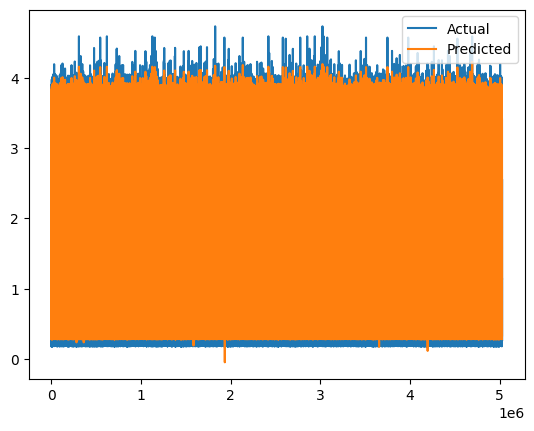

In [20]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

# Plot the results
plt.plot(y_test_original, label='Actual')
plt.plot(y_pred_original, label='Predicted')
plt.legend()
plt.show()


In [21]:
import pickle
# Save the model
model.save('lstm_model.h5')

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


In [22]:
# Generate predictions on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

157117/157117 ━━━━━━━━━━━━━━━━━━━━ 260s 2ms/step
Root Mean Squared Error (RMSE): 0.061720093144699395


In [23]:
# Measure latency on a single prediction
start_time = time.time()
model.predict(X_test[0:1])  # Predict on a single sample
end_time = time.time()

latency = end_time - start_time
print(f'Prediction Latency: {latency} seconds')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction Latency: 0.09684467315673828 seconds


In [24]:
# Measure latency on multiple samples
num_samples = 100000  # Number of samples to test
start_time = time.time()
model.predict(X_test[0:num_samples])  # Predict on multiple samples
end_time = time.time()

latency = (end_time - start_time) / num_samples
print(f'Prediction Latency for {num_samples} samples: {latency} seconds per sample')


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Prediction Latency for 100000 samples: 6.824542760848999e-05 seconds per sample


In [30]:
from tensorflow.keras.models import load_model

model = load_model('lstm_model.h5')

# Load the saved scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load the unseen data
unseen_data_path = '/content/high-frequency_dataset/minDataSum/A.csv'  # Replace with your unseen data file path
df_unseen = pd.read_csv(unseen_data_path)

# Drop non-numerical columns
df_unseen = df_unseen.select_dtypes(include=[np.number])

# Handle missing values (if any)
df_unseen.fillna(method='ffill', inplace=True)  # Forward fill missing values

# Prepare the data for prediction
X_unseen = df_unseen.drop(columns=['Close'])  # Assuming 'Close' is the target

# Reshape the data to fit the scaler's expectation (assuming it was trained on a single feature)
X_unseen_reshaped = X_unseen.values.reshape(-1, 1)  # Reshape to (n_samples, 1)

# Scale the reshaped data
X_unseen_scaled = scaler.transform(X_unseen_reshaped)

# Reshape the scaled data back to its original form
X_unseen = X_unseen_scaled.reshape(X_unseen.shape)

# Reshape for LSTM input (samples, timesteps, features)
X_unseen = X_unseen.reshape((X_unseen.shape[0], 1, X_unseen.shape[1]))

# Make predictions
predictions = model.predict(X_unseen)

# Example trading strategy with latency tracking
def trading_strategy_with_latency(predictions, initial_balance=10000):
    balance = initial_balance
    position = None
    buy_price = 0

    for i in range(len(predictions) - 1):
        start_time = time.time()

        if predictions[i] < predictions[i + 1]:  # Uptrend, consider buying
            if position != 'buy':
                buy_price = predictions[i]
                print(f"Bought at {buy_price}")
                position = 'buy'
        elif predictions[i] > predictions[i + 1]:  # Downtrend, consider selling
            if position == 'buy':
                sell_price = predictions[i]
                profit = sell_price - buy_price
                balance += profit
                print(f"Sold at {sell_price}, Profit: {profit}")
                position = None

        end_time = time.time()
        latency = end_time - start_time
        print(f"Latency for this operation: {latency} seconds")

    final_balance = balance
    profit = final_balance - initial_balance
    return final_balance, profit

# Apply trading strategy to predictions
final_balance, profit = trading_strategy_with_latency(predictions)
print(f"Final Balance: {final_balance}")
print(f"Profit: {profit}")


<ipython-input-30-70d2058969fa>:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_unseen.fillna(method='ffill', inplace=True)  # Forward fill missing values


Streaming output truncated to the last 5000 lines.
Latency for this operation: 0.00014591217041015625 seconds
Latency for this operation: 5.7220458984375e-06 seconds
Sold at [1.8865491], Profit: [1.0280972]
Latency for this operation: 0.0002505779266357422 seconds
Bought at [0.85845196]
Latency for this operation: 0.0001404285430908203 seconds
Latency for this operation: 3.814697265625e-06 seconds
Sold at [1.9001871], Profit: [1.0417352]
Latency for this operation: 0.000274658203125 seconds
Latency for this operation: 6.67572021484375e-06 seconds
Latency for this operation: 4.5299530029296875e-06 seconds
Latency for this operation: 4.291534423828125e-06 seconds
Latency for this operation: 4.5299530029296875e-06 seconds
Bought at [0.85845196]
Latency for this operation: 0.00013971328735351562 seconds
Latency for this operation: 5.4836273193359375e-06 seconds
Sold at [1.9001871], Profit: [1.0417352]
Latency for this operation: 0.0002524852752685547 seconds
Latency for this operation: 6.1